In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\02_signs_code'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\02_signs_code'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\02_signs_code'

### Libary Imports

In [21]:
# Core Libraries ========================================================
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Progress Bar ========================================================
from tqdm.auto import tqdm as notebook_tqdm
from tqdm import tqdm

# Plotting ========================================================
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter Inline Plots ========================================================
%matplotlib inline

# TensorFlow and Keras ========================================================
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Scikit-learn ========================================================
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# SciKeras ========================================================
from scikeras.wrappers import KerasClassifier

# PyTorch ========================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from itertools import zip_longest  # to interleave two loaders safely

print("import complete")

import complete


In [32]:
#2. Import the Dataset
##  Baron's Path
signs_dataset = r"C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs_0\db_lisa_tiny"

#Construct the Dataset
signs_df = pd.read_csv(f"{signs_dataset}/annotations.csv", delimiter = ",")

# Create a mapping: class name → index
class_id_to_index = {cls: idx for idx, cls in enumerate(signs_df["class"].unique())}

# Map class names to integers
signs_df["LabelIndex"] = signs_df["class"].map(class_id_to_index)



### Part B) Dataset Description and Visualizaton

    1. General Info
    2. Describing the Dataset
    3. Head of the Dataset
    4. Describing the characteristicts of the images
    4. Creating General Dataframes (For later use)
    5. Plot of the Widths and Heights for preprocessing

In [23]:
#1. General Info
signs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    900 non-null    object
 1   x1          900 non-null    int64 
 2   y1          900 non-null    int64 
 3   x2          900 non-null    int64 
 4   y2          900 non-null    int64 
 5   class       900 non-null    object
 6   LabelIndex  900 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 49.3+ KB


In [24]:
#signs_df.describe()

In [25]:
##  Baron's Path
signs_dataset = r"C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs_0\db_lisa_tiny\original"

# Add full path column
signs_df["full_path"] = signs_df["filename"].apply(lambda name: os.path.join(signs_dataset, name))

#3. Head of the Dataset (Used to see a quick glimpse of the dataset)
signs_df.head(120)

,filename,x1,y1,x2,y2,class,LabelIndex,full_path
0,sample_001.png,190,40,211,63,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
1,sample_002.png,4,246,43,283,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
2,sample_003.png,389,286,418,314,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
3,sample_004.png,307,243,315,251,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
4,sample_005.png,377,249,398,270,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
...,...,...,...,...,...,...,...,...
115,sample_116.png,422,47,447,70,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
116,sample_117.png,514,180,556,220,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
117,sample_118.png,568,280,592,305,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...
118,sample_119.png,359,212,382,235,stop,0,C:\Users\Baron\Documents\Grad_School\EE_297A\P...


In [26]:
print(signs_df.iloc[360]["full_path"])

C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs_0\db_lisa_tiny\original\sample_361.png


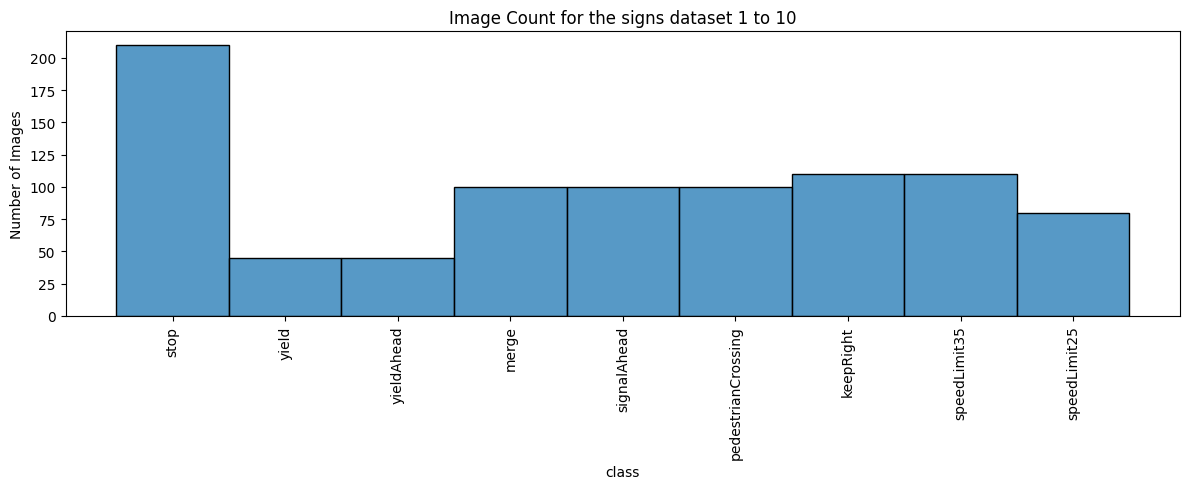

In [27]:
# Get sorted list of unique signs 
unique_classes = signs_df['class'].unique()
num_classes = len(unique_classes)
step = 10

for i in range(0, num_classes, step):
    subset = unique_classes[i:i+step]
    plt.figure(figsize=(12, 5))
    sns.histplot(data=signs_df[signs_df['class'].isin(subset)],
                 x='class', bins=step, kde=False)
    plt.xticks(rotation=90)
    plt.title(f"Image Count for the signs dataset {i+1} to {i+step}")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

In [28]:
# Classes to remove due to low count
drop_classes = ["yield", "yieldAhead", "speedLimit25"]

# Create a new DataFrame without those classes
signs_df = signs_df[~signs_df["class"].isin(drop_classes)].reset_index(drop=True)

In [35]:
# Map classes to index based on first appearance
class_id_to_index = {cls: idx for idx, cls in enumerate(signs_df["class"].unique())}
signs_df["LabelIndex"] = signs_df["class"].map(class_id_to_index)

# Count samples per label index
label_counts = signs_df["LabelIndex"].value_counts().sort_index()

class_id_to_index

{'stop': 0,
 'yield': 1,
 'yieldAhead': 2,
 'merge': 3,
 'signalAhead': 4,
 'pedestrianCrossing': 5,
 'keepRight': 6,
 'speedLimit35': 7,
 'speedLimit25': 8}

In [30]:
class_counts = signs_df["class"].value_counts().sort_index()
print(class_counts)

class
keepRight             110
merge                 100
pedestrianCrossing    100
signalAhead           100
speedLimit35          110
stop                  210
Name: count, dtype: int64


In [31]:
# Assume your dataframe is called `df` and has a 'class' column
TARGET_COUNT = 100

# Group by class and sample 100 per class
signs_df = (
    signs_df.groupby('class', group_keys=False)
    .apply(lambda x: x.sample(n=TARGET_COUNT, random_state=42))
)

# Optional: Shuffle the final dataset
signs_df = signs_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check result
print(signs_df['class'].value_counts())

class
merge                 100
speedLimit35          100
stop                  100
keepRight             100
pedestrianCrossing    100
signalAhead           100
Name: count, dtype: int64


In [38]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# === CONFIG ===
root_dir = r"C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs_0\db_lisa_tiny"
original_dir = os.path.join(root_dir, "original")
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
annotations_path = os.path.join(root_dir, "annotations.csv")
annotations_test_csv = os.path.join(root_dir, "annotations_test.csv")
class_map_csv = os.path.join(root_dir, "class_to_index.csv")

# === Load CSV ===
df = pd.read_csv(annotations_path)

# Ensure filepaths are present
if 'filepath' not in df.columns:
    if 'filename' in df.columns:
        df['filepath'] = df['filename'].apply(lambda x: os.path.join(original_dir, x))
    else:
        raise ValueError("CSV must contain 'filepath' or 'filename' column.")

# === Use FIRST APPEARANCE ORDER for class indexing
class_id_to_index = {cls: idx for idx, cls in enumerate(df["class"].unique())}
df["LabelIndex"] = df["class"].map(class_id_to_index)

# Save class-to-index mapping
pd.DataFrame(list(class_id_to_index.items()), columns=["class", "index"]).to_csv(class_map_csv, index=False)

# Ensure train and test directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# === Split and copy
test_rows = []

for class_name, group in df.groupby("class"):
    class_idx = class_id_to_index[class_name]

    # Split into 90% train / 10% test
    train_split, test_split = train_test_split(
        group, test_size=0.1, random_state=42, shuffle=True
    )

    # === TRAIN: copy to train/<class_idx>/
    class_train_dir = os.path.join(train_dir, str(class_idx))
    os.makedirs(class_train_dir, exist_ok=True)

    for _, row in train_split.iterrows():
        src = row['filepath']
        if os.path.exists(src):
            dst = os.path.join(class_train_dir, os.path.basename(src))
            shutil.copy(src, dst)

    # === TEST: copy to flat test/ folder
    for _, row in test_split.iterrows():
        src = row['filepath']
        if os.path.exists(src):
            dst = os.path.join(test_dir, os.path.basename(src))
            shutil.copy(src, dst)
            test_rows.append(row)

# === Save annotations_test.csv
# Save test annotations with corrected test filepaths
if test_rows:
    test_df = pd.DataFrame(test_rows)
    test_df["filepath"] = test_df["filename"].apply(lambda x: os.path.join(test_dir, x))
    test_df.to_csv(annotations_test_csv, index=False)
    print(f"✅ Test annotations saved to: {annotations_test_csv}")
    print(f"📁 Class-to-index mapping saved to: {class_map_csv}")
else:
    print("⚠️ No test data saved. Check file paths or annotation format.")


✅ Test annotations saved to: C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs_0\db_lisa_tiny\annotations_test.csv
📁 Class-to-index mapping saved to: C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs_0\db_lisa_tiny\class_to_index.csv


### Part C) Image Set Preprocessing

In [39]:
original_dir_train = os.path.join(signs_dataset, 'train')
original_dir_test = os.path.join(signs_dataset, 'test') 

processed_dir_train = os.path.join(signs_dataset, 'train_p')
processed_dir_test = os.path.join(signs_dataset, 'test_p')

In [42]:
from PIL import Image
from tqdm import tqdm

# Target size
target_size = (640, 640)

# Walk through all subfolders and images
for root, dirs, files in os.walk(original_dir_train):
    for file in tqdm(files, desc="Processing images"):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Full path to original image
            img_path = os.path.join(root, file)

            # Create corresponding path in new directory
            relative_path = os.path.relpath(img_path, original_dir_train)
            new_path = os.path.join(processed_dir_train, relative_path)

            # Create subdirectory if it doesn't exist
            os.makedirs(os.path.dirname(new_path), exist_ok=True)

            try:
                # Open, resize, and save image
                img = Image.open(img_path).convert('RGB')
                img_resized = img.resize(target_size)
                img_resized.save(new_path)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

Processing images: 0it [00:00, ?it/s]
Processing images: 100%|█████████████████████████████████████████████████████████████| 112/112 [00:11<00:00,  9.63it/s]


### Bounding boxes test and setup
    1.) 

### Part D) Baseline Model Training
    Contents include the prototyping of different pretained models
    1.) ResNet18
    2.) MobileNet
    3.) Yolov7